In [1]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
from random import randint

In [2]:
work_dir = "./Alzheimers-ADNI/train/"

In [4]:
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['AD', 'EMCI', 'LMCI', 'MCI', 'NC']


In [5]:
WORK_DIR = "./Alzheimers-ADNI/train/"

CLASSES = [ 'AD',
            'EMCI',
            'LMCI',
            'MCI',
          'CN']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.5, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 1101 images belonging to 5 classes.


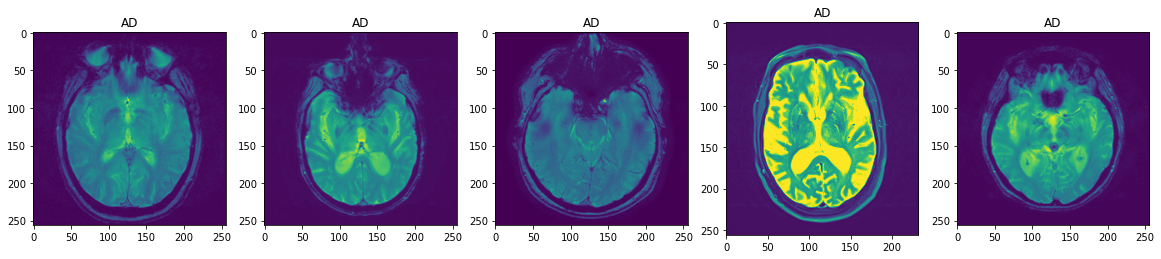

In [8]:
import random
import matplotlib.image as mpimg
plt.figure(figsize=(20,20))
test_folder="./Alzheimers-ADNI/train/AD"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    plt.title('AD')
    plt.imshow(img)

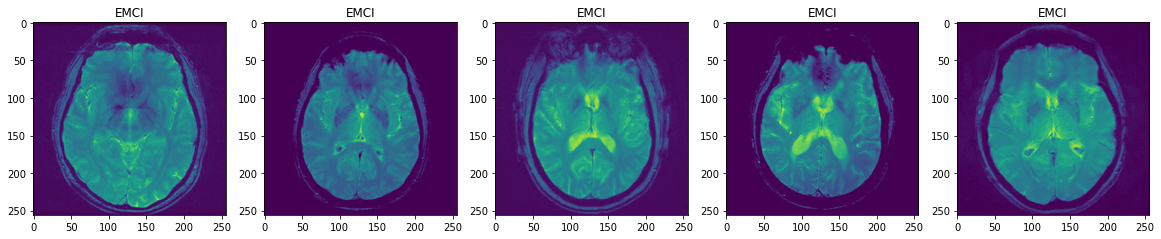

In [31]:
import random
import matplotlib.image as mpimg
plt.figure(figsize=(20,20))
test_folder="./Alzheimers-ADNI/train/EMCI"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    plt.title('EMCI')
    plt.imshow(img)

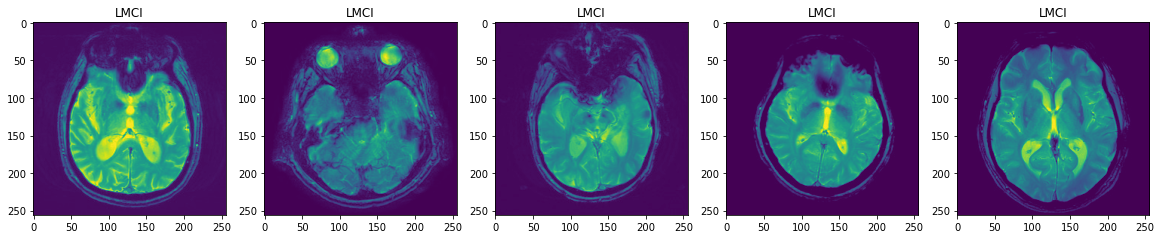

In [30]:
import random
import matplotlib.image as mpimg
plt.figure(figsize=(20,20))
test_folder="./Alzheimers-ADNI/train/LMCI"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    plt.title('LMCI')
    plt.imshow(img)

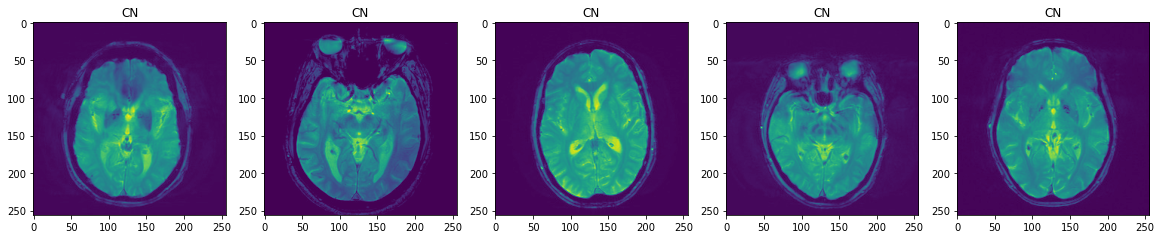

In [25]:
import random
import matplotlib.image as mpimg
plt.figure(figsize=(20,20))
test_folder="./Alzheimers-ADNI/train/NC"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    plt.title('CN')
    plt.imshow(img)

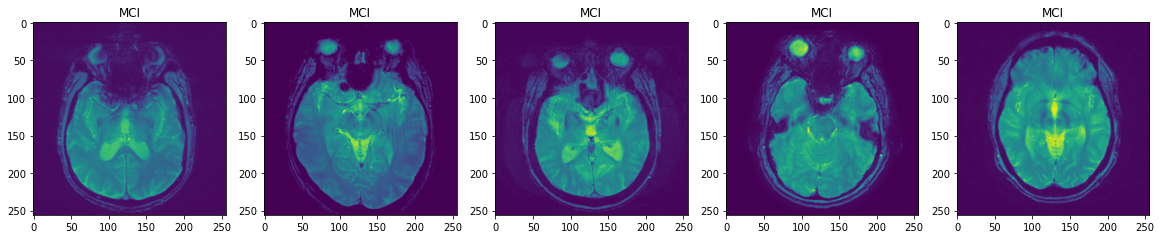

In [28]:
import random
import matplotlib.image as mpimg
plt.figure(figsize=(20,20))
test_folder="./Alzheimers-ADNI/train/MCI"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    plt.title('MCI')
    plt.imshow(img)

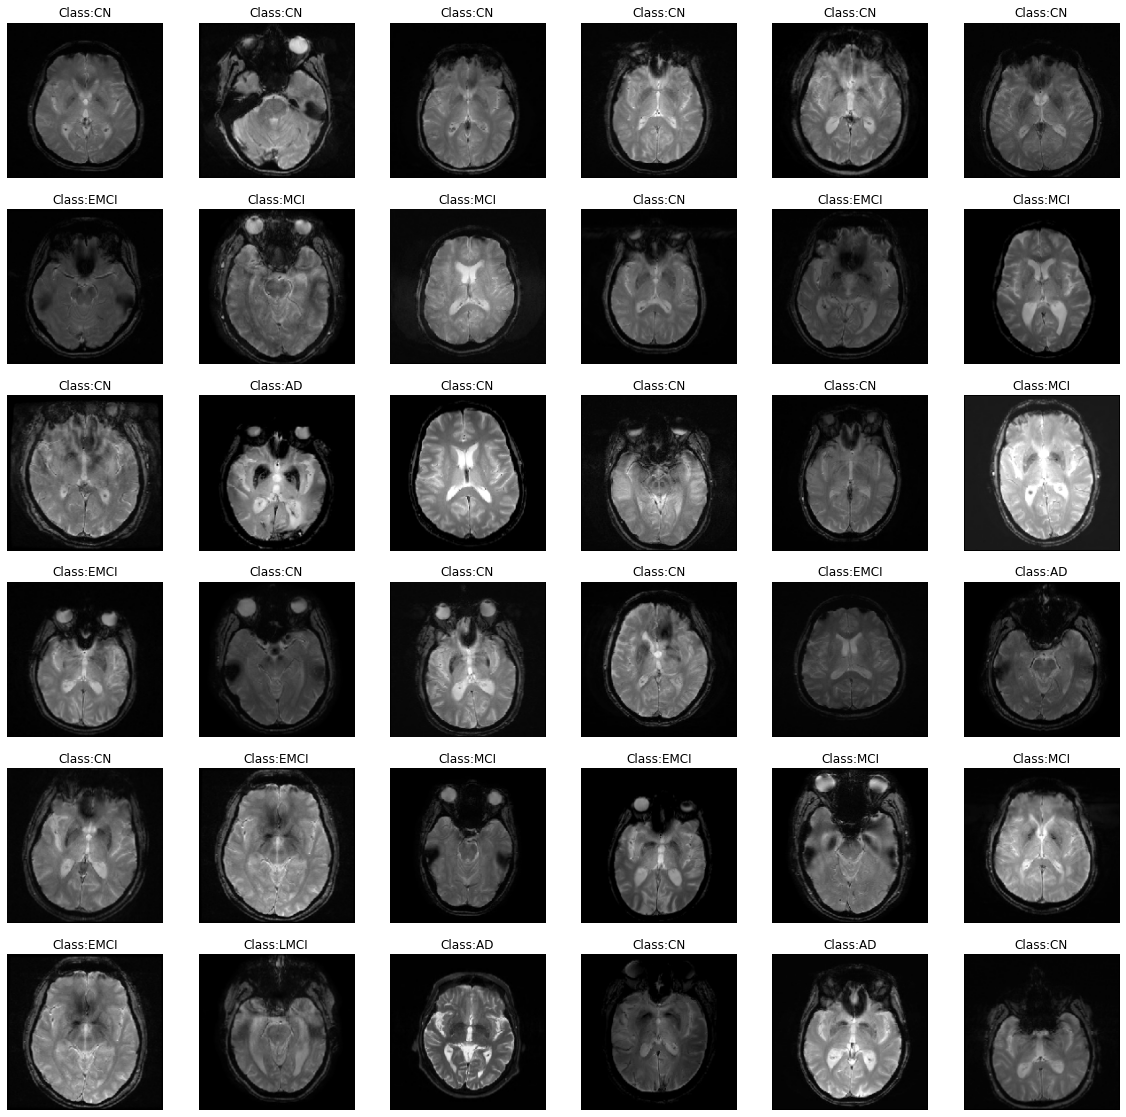

In [32]:
def show_images(generator,y_pred=None):
    # get image lables
    labels =dict(zip([0,1,2,3,4], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(20, 20))
    if y_pred is None:
        for i in range(36):
            ax = plt.subplot(6, 6, i + 1)
            idx = randint(0, 1000)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
# Display Train Images
show_images(train_data_gen)

In [9]:
#Retrieving the data from the ImageDataGenerator iterator
train_data, train_labels = train_data_gen.next()

In [10]:
print(train_data.shape, train_labels.shape)

(1101, 176, 176, 3) (1101, 5)


In [11]:
#Performing over-sampling of the data, since the classes are imbalanced
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(2465, 176, 176, 3) (2465, 5)


In [12]:
#Data Split
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [13]:
print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)
print(test_data.shape, test_labels.shape)

(1577, 176, 176, 3) (1577, 5)
(395, 176, 176, 3) (395, 5)
(493, 176, 176, 3) (493, 5)


In [14]:
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [15]:
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [16]:
def construct_model(act='relu'):
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.15),
        conv_block(256),
        Dropout(0.15),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(5, activation='softmax')        
    ], name = "cnn_model")

    return model

In [17]:
#Defining a custom callback function to stop training our model when accuracy goes above 97%
from tensorflow.keras.callbacks import EarlyStopping
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.97:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [18]:
#Defining other parameters for our CNN model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout
import tensorflow_addons as tfa
model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=5)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                         

In [34]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=100)

Epoch 1/100
256/256 [==============================] - 561s 2s/step - loss: 1.6352 - acc: 0.3304 - auc: 0.5829 - f1_score: 0.3279 - val_loss: 2.5924 - val_acc: 0.2856 - val_auc: 0.5154 - val_f1_score: 0.1689
Epoch 2/100
256/256 [==============================] - 544s 2s/step - loss: 0.9799 - acc: 0.5480 - auc: 0.8236 - f1_score: 0.5359 - val_loss: 4.1806 - val_acc: 0.3672 - val_auc: 0.6103 - val_f1_score: 0.2542
Epoch 3/100
256/256 [==============================] - 537s 2s/step - loss: 0.7782 - acc: 0.6327 - auc: 0.8866 - f1_score: 0.6229 - val_loss: 1.1998 - val_acc: 0.4844 - val_auc: 0.7596 - val_f1_score: 0.4974
Epoch 4/100
256/256 [==============================] - 538s 2s/step - loss: 0.6955 - acc: 0.6703 - auc: 0.9091 - f1_score: 0.6630 - val_loss: 1.1337 - val_acc: 0.5508 - val_auc: 0.8336 - val_f1_score: 0.5307
Epoch 5/100
256/256 [==============================] - 532s 2s/step - loss: 0.6606 - acc: 0.7001 - auc: 0.9194 - f1_score: 0.6965 - val_loss: 0.8303 - val_acc: 0.6587 -

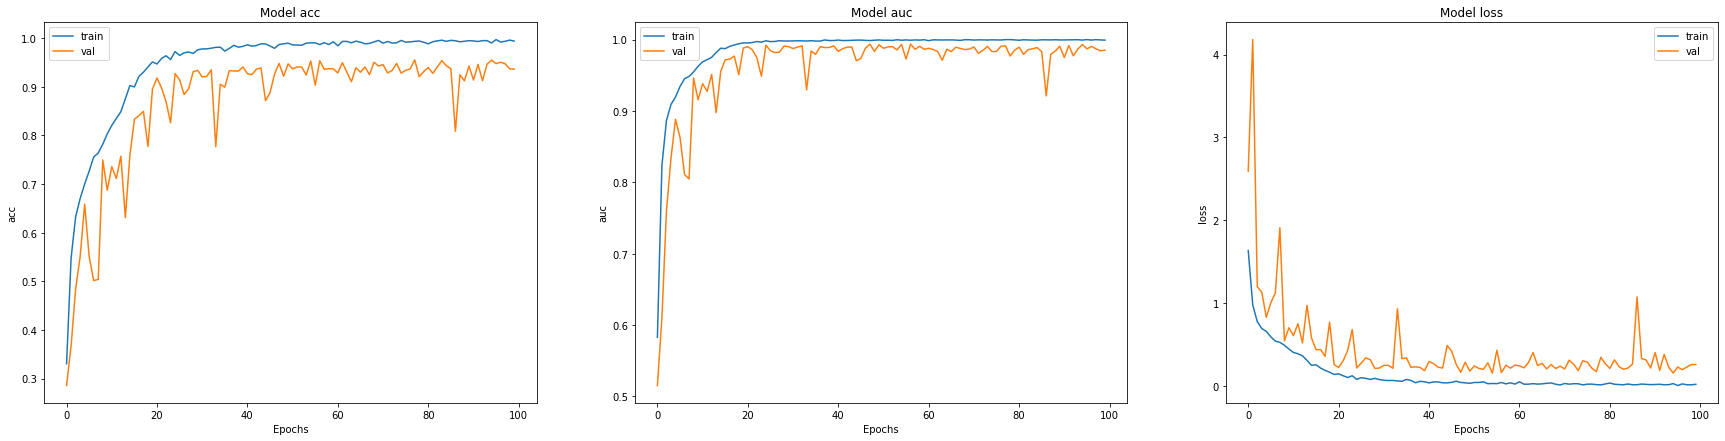

In [37]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 7))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [38]:
#Test

train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 45s 559ms/step - loss: 0.2713 - acc: 0.9270 - auc: 0.9857 - f1_score: 0.9264
Training Accuracy: 99.32%
Validation Accuracy: 93.65%
Testing Accuracy: 92.70%


In [22]:
pred_labels = model.predict(test_data)

In [23]:
#Print the classification report of the tested data
from sklearn.metrics import classification_report, confusion_matrix
#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
   
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

              precision    recall  f1-score   support

          AD       0.93      0.90      0.91        88
        EMCI       0.80      0.81      0.80        99
        LMCI       0.94      0.99      0.96       105
         MCI       0.84      0.81      0.82       108
          CN       0.65      0.66      0.65        93

   micro avg       0.83      0.83      0.83       493
   macro avg       0.83      0.83      0.83       493
weighted avg       0.83      0.83      0.83       493
 samples avg       0.83      0.83      0.83       493



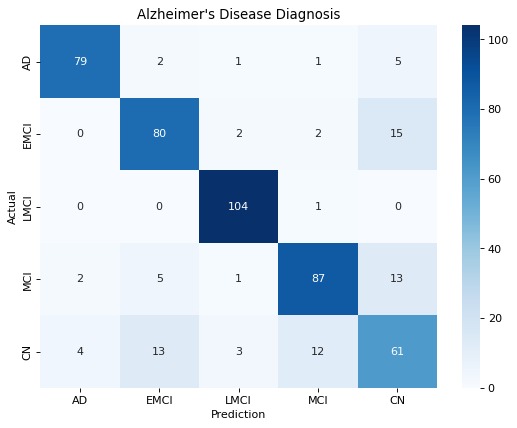

In [24]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show(ax)

In [ ]:
#Printing some other classification metrics
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 92.77 %
Matthew's Correlation Coefficient: 90.47 %


In [43]:
#Saving the model for future use

model_dir = work_dir + "adnicnn"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['AD', 'adnicnn', 'EMCI', 'LMCI', 'MCI', 'NC']

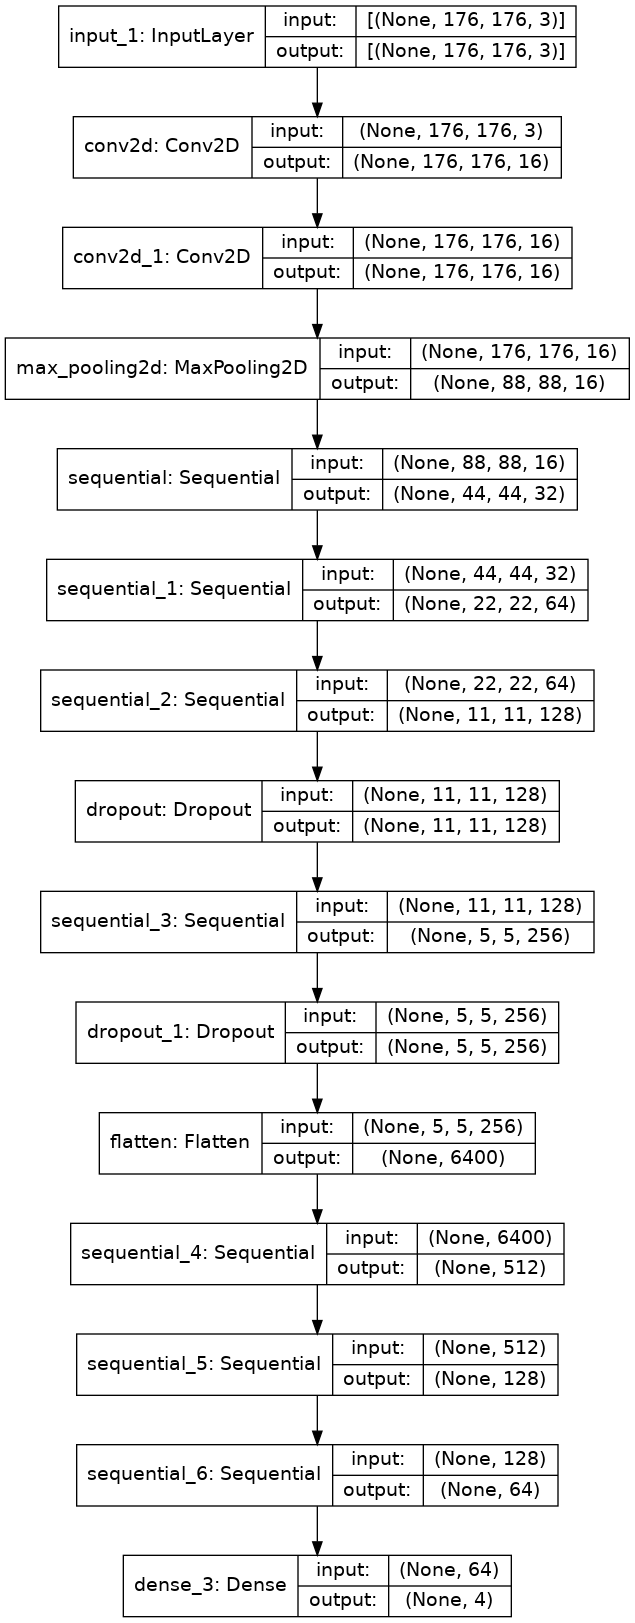

In [ ]:
pretrained_model = tf.keras.models.load_model(model_dir)
from keras.utils.vis_utils import plot_model
#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

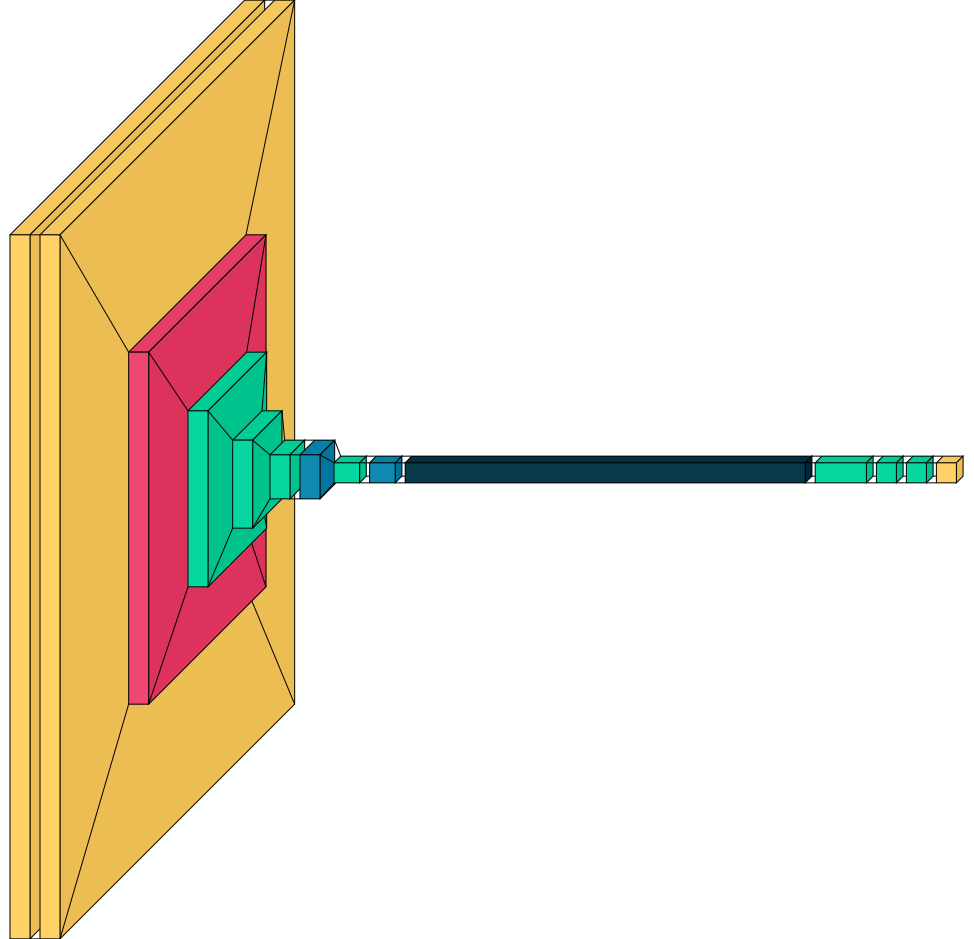

In [45]:
import visualkeras
visualkeras.layered_view(model)